# API for getting data from Google trend

In [1]:
# %load GoogleTrendAPI
import datetime as dt
import os
import pandas as pd

from pytrends.request import TrendReq


class GoogleTrendAPI:
    """
    get Google Trend data. Input: keyword, start date, end date. Output: data frame save to csv
    call method: self.get_data
    """

    def __init__(self):
        self.file_name = 'data/google_trend_data.csv'
        self.keyword = 'bitcoin'
        self.Date_format = '%Y-%m-%d'
        # self.data
        if os.path.isfile(self.file_name): # if file exists
            print(self.file_name, ": Google trend data file exist and will be loaded")  # scaffolding code
            self.data = pd.read_csv(self.file_name, parse_dates=['Date'])  # parsing column 'Date' as a date column
        else:
            self.data = None
            print(self.file_name,": Google trend data file does not exist")  # scaffolding code
        self.pytrend = TrendReq()  # connect to Google

    def get_data(self, start, end):  # the only method that will be called from outside.
        if self.data is None:
            self.load_data(start, end)
            return self.data
        if end > self.data['Date'].max():  # load additional data if the end date is after last date in available data
            print('loading additional data from ', self.data['Date'].max(), 'to, ', end)
            self.load_data(self.data['Date'].max(), end)
        return self.data[((self.data['Date'] >= start) & (self.data['Date'] <= end))]

    def load_data(self, start, end): # self is passed explicitly when define, but implicitly & automatically when called
        # count=0
        while start < end - dt.timedelta(days=30):
            if self.data is None:
                self.data = self.get_py_trend(start, start + dt.timedelta(30)) # return data frame
            self.data = self.merge(self.data, self.get_py_trend(start, start + dt.timedelta(30))) # merging old data
            print('start: ', start, 'end: ', start + dt.timedelta(30))  
            start += dt.timedelta(30)
            # count += 1
            # print('# of calls', count)

        # x = self.data['bitcoin'][2] # test
        # quit()
        if start < end:  # merging the last chunk of days
            self.data = self.merge(self.data, self.get_py_trend(start, end))
        self.close()

    def get_py_trend(self, start, end):
        date_range = start.strftime(self.Date_format) + ' ' + end.strftime(self.Date_format)
        # string from time, target format is Date_format
        self.pytrend.build_payload(kw_list=[self.keyword], timeframe=date_range)
        # get Google trend data with keyword and everyday inside the date_range
        data_temp = self.pytrend.interest_over_time().reset_index()
        # returns historical, indexed data for when the keyword was searched most as shown on Google Trends'
        # Interest Over Time section
        # reset_index() remove index levels (bring date and bitcoin to the same row)

        if data_temp is None or data_temp.empty:
            return
        df = data_temp[['date', self.keyword]].rename(columns={'date': 'Date'})
        # select the list of column [date , keyword], rename date to Date
        #  pd.set_option('display.max_columns', None)
        #  print(df.iloc[0:5])
        #  quit()
        return df

    def merge(self, df1, df2):  # merge and renormalize
        if df2 is None:
            return df1
        overlap = (set(df1['Date'].unique()) & set(df2['Date'].unique())).pop()
        # return the intersection of two sets of unique dates
        print('overlap',overlap)
        # quit()
        # raise('continue here')
        df1_val = df1[(df1['Date'] == overlap)][self.keyword].sum() #
        df2_val = df2[(df2['Date'] == overlap)][self.keyword].sum()
        df2[self.keyword] = df2[self.keyword] / df2_val * df1_val
        # normalize to df1 values because on overlap dates, the value must be equal
        df = pd.concat([df1, df2], ignore_index=True)
        df = df.drop_duplicates('Date')
        df = df.sort_values(by='Date')
        return df

    def get_current(self):
        """Update the data to current date"""
        date_max = self.data['Date'].max()
        if date_max < dt.datetime.today():
            df = self.get_py_trend(date_max, dt.datetime.today())
            if df is not None:
                if not df.empty:
                    self.data = self.merge(self.data, df)
        return self.data.loc[(self.data['Date'] == self.data['Date'].max())].to_dict(orient='records')[0]

    def close(self):
        for col in self.data:
            if col.startswith('Unnamed'):
                self.data.drop(columns=[col])
        self.data.to_csv(self.file_name, index=False)  # save to csv file: make-shift database



# API for getting finance data from Yahoo 

In [2]:
# %load FinanceAPI.py
import datetime as dt
import os

import pandas as pd
import pandas_datareader.data as web


class FinanceAPI:

    def __init__(self):
        self.file_name = 'data/finance_data.csv'
        if os.path.isfile(self.file_name):
            print(self.file_name, 'finance data file exists and will be loaded')
            self.data = pd.read_csv(self.file_name, parse_dates=['Date'])
        else:
            self.data = None
            print(self.file_name, ": finance data file does not exist")  # scaffolding code

    def get_data(self, start, end):  # the only function that's called from outside
        if self.data is None:
            self.load_data(start, end)
            return self.data
        if end.date() > self.data['Date'].max().date():
            print('loading additional data from ', self.data['Date'].max().date(), 'to, ', end.date())
            self.load_data(self.data['Date'].max() + dt.timedelta(days=1), end)
        return self.data[((self.data['Date'] >= start) & (self.data['Date'] <= end))]

    def load_data(self, start, end):
        """Load the data from web from start to end day and do some cleaning"""
        df = web.DataReader(['^GSPC', '^VIX'], 'yahoo', start, end)  # shape ( days ,12)
        df = df['Adj Close'].reset_index()  # making Date a col, new shape ( days ,3), columns = Date, ^GSPC, ^VIX

        df_btc = web.DataReader('BTC-USD', 'yahoo', start, end)  # shape (days, 6)
        # pd.set_option('display.max_columns', None)
        # print(df_btc.iloc[0:5])
        # quit()
        df_btc_volume = df_btc['Volume'].reset_index()  # shape (days, 2), columns = Date, Volume
        df_btc_price = df_btc['Adj Close'].reset_index()  # shape (days, 2), columns = Date, Adj Close (close price)

        df = df.merge(df_btc_volume, how='outer', on=['Date']).merge(df_btc_price, how='outer', on=['Date']).rename(
            columns={'Adj Close': 'BTC-USD'})
        # shape (days,5), columns  = Date , ^GSPC , ^VIX, Volume , BTC-USD

        df = df.sort_values(by='Date')
        for col in df.columns:
            df[col] = df[col].ffill()  # fill NaN by propagating non-null values forward in time
        if self.data is None:
            self.data = df
        else:
            self.data = pd.concat([self.data, df], ignore_index=True)  # concatenate
        self.close()  # save to file

    def get_current(self):
        """Update the data to current date"""
        end = datetime.datetime.today()
        start = end - datetime.timedelta(days=5)
        self.data = self.data[(self.data['Date'] < start)]
        self.load_data(start, end)
        return self.data.loc[(self.data['Date'] == self.data['Date'].max())].to_dict(orient='records')[0]

    def close(self):
        for col in self.data:
            if col.startswith('Unnamed'):
                self.data.drop(columns=[col])
        self.data.to_csv(self.file_name, index=False)  # save to csv file: make-shift database


# Collect data, visualize and prep for ML

In [3]:
#from GoogleTrendAPI import GoogleTrendAPI
#from FinanceAPI import FinanceAPI
import matplotlib.pyplot as plt

class Data:
    def __init__(self, finance_api=None, google_trend_api=None):
        """Constructor: Initiate finance_api and google_trend_api
        """
        self.finance_api = finance_api if finance_api is not None else FinanceAPI()   # initiate finance api if not
        # provided (default)
        self.google_trend_api = google_trend_api if google_trend_api is not None else GoogleTrendAPI()
        # initiate Google api if not provided (default)
    
    def gather_data(self,start,end):
        """Gather the data from the Google and Yahoo APIs
        return a merged data frame
        """
        google_trend_df = self.google_trend_api.get_data(start, end)
        # shape (days,2), columns  = Date , bitcoin
        finance_df = self.finance_api.get_data(start, end)
        # shape (days,5), columns  = Date , ^GSPC , ^VIX, Volume , BTC-USD
        df = finance_df.merge(google_trend_df, on=['Date'])
        df = df.dropna()
        return df
        
    def train_data(self,start,end):
        """train data, first 2/3 of the data range"""
        df = self.gather_data(start,end)
        df_train = df[:int(df.shape[0]*2/3)] 
        X_train = df_train[['^GSPC', '^VIX', 'Volume', 'bitcoin']]  # input
        y_train = df_train['BTC-USD'] #
        
        return (X_train, y_train)
        
    def test_data(self,start,end):
        """test data, last 1/3 of the data range"""
        df = self.gather_data(start,end)
        df_test = df[int(df.shape[0]*2/3):] 
        X_test = df_test[['^GSPC', '^VIX', 'Volume', 'bitcoin']]  # input
        y_test = df_test['BTC-USD'] #
        
        return (X_test,y_test)

    def plot_data(self,start,end):
        """Plot the train data"""
        X,y=self.train_data(start,end) # get the train data
        # plotting
        f = plt.figure(figsize=(10, 10))
        ax = f.add_subplot(2,2,1)
        ax.plot(X.index, X[['^GSPC']],'o-')
        ax.set_xlabel('days since '+ str(start.year) + '-' + str(start.month) + '-' + str(start.day))
        ax.set_ylabel('GSPC')
        ax = f.add_subplot(2, 2, 2)
        ax.plot(X.index, X[['^VIX']],'o-')
        ax.set_xlabel('days since '+ str(start.year) + '-' + str(start.month) + '-' + str(start.day))
        ax.set_ylabel('VIX')
        ax = f.add_subplot(2, 2, 3)
        ax.plot(X.index, X[['Volume']],'o-')
        ax.set_xlabel('days since '+ str(start.year) + '-' + str(start.month) + '-' + str(start.day))
        ax.set_ylabel('Volume')
        ax = f.add_subplot(2, 2, 4)
        ax.plot(X.index, X[['bitcoin']],'o-')
        ax.set_xlabel('days since '+ str(start.year) + '-' + str(start.month) + '-' + str(start.day))
        ax.set_ylabel('Google Trend for \'bitcoin\' ')
        
        f2 =plt.figure(figsize=(5,5))
        plt.plot(y.index,y,'o-')
        plt.xlabel('days since '+ str(start.year) + '-' + str(start.month) + '-' + str(start.day))
        plt.ylabel('True Bitcoin price')
    

# Base ML model

In [4]:
import os
# from sklearn.externals\
import joblib
import pandas as pd

# from Data import Data

class GenericModel:
    """Abstract class
    Class variables MODEL_NAME, MODEL_CLASS, EXTRA_MODEL_ARGS are to be overwritten by child class
    Class methods:
    __init__:  model
    train: train the model given by MODEL_CLASS or saved in MODEL_NAME
    predict: predict bitcoin price
    score: calculate R^2 score, using data from recent dates as test data
    save: save model to MODEL_NAME
    """
    MODEL_NAME = ''  # file path of saved model. to be be overwritten by child class
    MODEL_CLASS = None  # to be overwritten by child class
    EXTRA_MODEL_ARGS = {}  # to be overwritten by child class
    

    def __init__(self):
        """Constructor: initiate model by loading or new instance """
        
        if os.path.isfile(self.MODEL_NAME):  # Return True if 'MODEL_NAME' is an existing regular file
            self.model = joblib.load(self.MODEL_NAME) # load the model from file
            print(self.MODEL_NAME,'model file exists and loaded')  # scaffolding code
        else:  # call an instance of model class (from scikit-learn)
            self.model = self.MODEL_CLASS(**self.EXTRA_MODEL_ARGS)  #
                  

    def train(self, X, y):
        """ Train the model with data
        INPUT: model object, start date, end date
        OUTPUT: return None, fit the model to data
        """
        self.model.fit(X, y)  # fit the data to the model
  

    def predict(self, attributes):
        """Predict using the linear model
        INPUT: finance data '^GSPC', '^VIX', 'Volume' and Google Trend data for 'bitcoin'
        OUTPUT: bitcoin price
        """
        df = pd.DataFrame([attributes], columns=['^GSPC', '^VIX', 'Volume', 'bitcoin'])
        return self.model.predict(df)

    def score(self,X,y):
        """Return the coefficient of determination R^2 of the prediction
        using data from recent dates as test data
        R = 1 means prediction = true (ideal case), R = 0 means prediction always = mean(true)"""

        return self.model.score(X, y)

    def save(self):  # save model object to file, path given by MODEL_NAME
        joblib.dump(self.model, self.MODEL_NAME)


# Inherited model: LinearRegression

In [5]:
# %load LinearRegressionModel.py
from sklearn.linear_model import LinearRegression
# from GenericModel import GenericModel

class LinearRegressionModel(GenericModel):
    """ inherit from GenericModel class. overwrite two class variables, MODEL_NAME and MODEL_CLASS:
    """
    MODEL_NAME = 'model/LinearRegression.mdl'
    MODEL_CLASS = LinearRegression

# Run the program

model/LinearRegression.mdl model file exists and loaded
data/finance_data.csv finance data file exists and will be loaded
data/google_trend_data.csv : Google trend data file exist and will be loaded
loading additional data from  2020-12-19 00:00:00 to,  2021-01-21 22:42:08.572058
overlap 2020-12-19T00:00:00.000000000
start:  2020-12-19 00:00:00 end:  2021-01-18 00:00:00
loading additional data from  2020-12-21 to,  2021-01-21
loading additional data from  2021-01-16 00:00:00 to,  2021-01-21 22:42:08.572058
overlap 2021-01-16T00:00:00.000000000
Given ^GSPC =  3319.47 , ^VIX =  25.83 , Volume =  22825594880 , Google Trend bitcoin = 65
Predicted price of Bitcoin: [9850.76966561]
loading additional data from  2021-01-16 00:00:00 to,  2021-01-21 22:42:08.572058
overlap 2021-01-16T00:00:00.000000000
R^2 score:  -0.1636021705210473


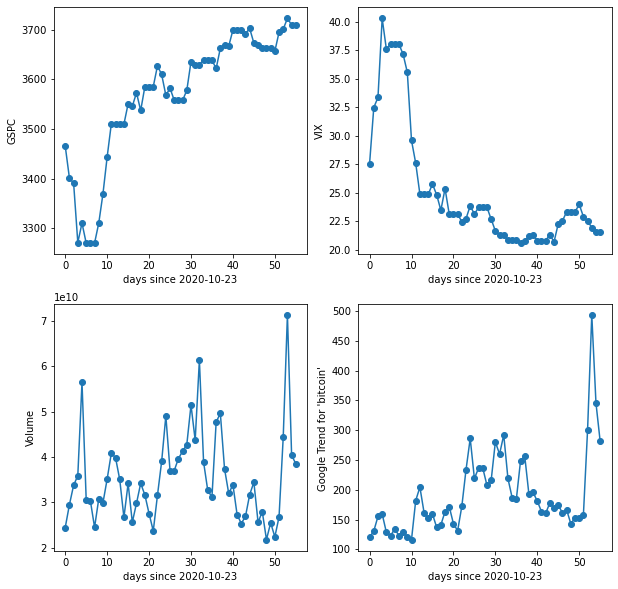

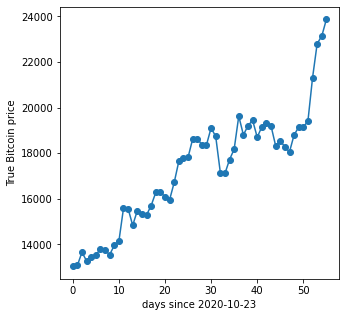

In [6]:
import datetime as dt

model = LinearRegressionModel() # Initiate a model

# choose the time range of data: 
start_date, end_date = dt.datetime.today() - dt.timedelta(days=90), dt.datetime.today() 
data = Data()
data.plot_data(start_date,end_date)
X,y = data.train_data(start_date,end_date)

model.train(X,y)  # train the model on data
# print('finish training')
# model.save()

# # INPUT VALUES FOR ['^GSPC', '^VIX', 'Volume', 'bitcoin']
xtest = [3319.47, 25.83, 22825594880, 65]
print('Given ^GSPC = ', xtest[0], ', ^VIX = ', xtest[1], ', Volume = ', xtest[2], ', Google Trend bitcoin =', xtest[3])
print('Predicted price of Bitcoin:', model.predict(xtest))

X_,y_ = data.test_data(start_date,end_date)
print('R^2 score: ', model.score(X_,y_))


In [ ]:
# plot prediction and true price comparision vs time
# discuss the metrics of prediction: how good is it really?
# are these data relevant?
# is the method relevant?